## Importing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

## Loading data

In [2]:
def read_data(filename):
    df = pd.read_csv(filename)
    df = df.rename(columns={'spacegroup': 'sg',
                            'number_of_total_atoms': 'Natoms',
                            'percent_atom_al': 'xAl',
                            'percent_atom_ga': 'xGa',
                            'percent_atom_in': 'xIn',
                            'lattice_vector_1_ang': 'a',
                            'lattice_vector_2_ang': 'b',
                            'lattice_vector_3_ang': 'c',
                            'lattice_angle_alpha_degree': 'alpha',
                            'lattice_angle_beta_degree': 'beta',
                            'lattice_angle_gamma_degree': 'gamma',
                            'formation_energy_ev_natom': 'Ef',
                            'bandgap_energy_ev': 'Eg'})
    return df

In [3]:
train = read_data('./train.csv')
test = read_data('./test.csv')
full = [train, test] 

vector_labels = ['a', 'b', 'c']
angle_labels = ['alpha', 'beta', 'gamma']
composition_labels = ['xAl', 'xGa', 'xIn']

## Data Exploration

### Spacegroups
Check which spacegroups train and test sets contain.

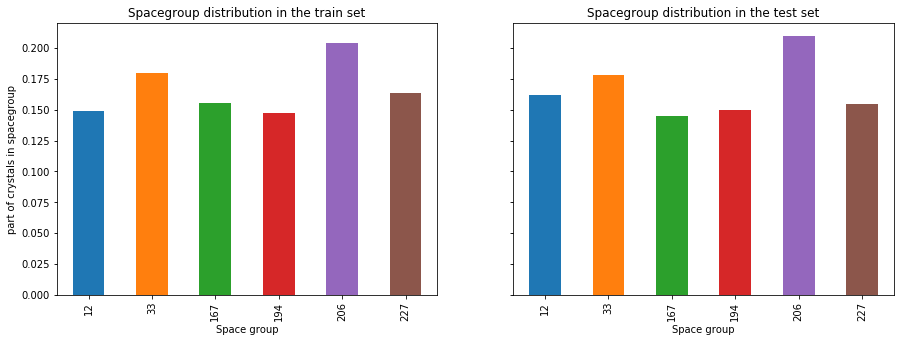

In [4]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
titles = [f'Spacegroup distribution in the {i} set' for i in ['train', 'test']]

for i in range(2):
    full[i]['sg'].value_counts(normalize=True).sort_index().plot.bar(ax=ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Space group')
ax[0].set_ylabel('part of crystals in spacegroup')
plt.show()

Train and test sets have the same spacegroups.

### Number of atoms

Train set:

In [5]:
pd.crosstab(train['Natoms'], train['sg'])

sg,12,33,167,194,206,227
Natoms,,,,,,
10.0,0,0,0,13,0,0
20.0,84,0,0,0,0,0
30.0,0,0,326,0,0,0
40.0,0,126,0,0,0,393
60.0,0,0,48,0,0,0
80.0,274,306,0,340,490,0


Test set:

In [6]:
pd.crosstab(test['Natoms'], test['sg'])

sg,12,33,167,194,206,227
Natoms,,,,,,
10.0,0,0,0,7,0,0
20.0,27,0,0,0,0,0
30.0,0,0,73,0,0,0
40.0,0,30,0,0,0,93
60.0,0,0,14,0,0,0
80.0,70,77,0,83,126,0


### Lattice angles

In [7]:
test.groupby('sg')[angle_labels].describe().xs(slice('mean', 'std'), level=1, axis=1)

,alpha,alpha,beta,beta,gamma,gamma
sg,,,,,,
12,89.999853,0.000296,104.560765,0.538130,90.000115,0.000053
33,90.001598,0.002282,90.000267,0.001955,90.000840,0.000530
167,89.993017,0.004548,90.007460,0.005040,120.001075,0.000513
194,90.010834,0.006072,90.003639,0.006037,119.996086,0.005977
206,90.002587,0.001451,90.002714,0.001352,89.997291,0.001588
227,91.043244,2.422655,90.836886,2.506604,73.757023,45.023798


In [8]:
train.groupby('sg')[angle_labels].describe().xs(slice('mean', 'std'), level=1, axis=1)

,alpha,alpha,beta,beta,gamma,gamma
sg,,,,,,
12,89.999838,0.000290,104.572380,0.525823,90.000112,0.000058
33,90.001709,0.002258,90.000445,0.001798,90.000840,0.000513
167,89.993366,0.004110,90.007081,0.004660,120.001058,0.000466
194,90.011335,0.006336,90.002652,0.005360,119.995280,0.005568
206,90.002605,0.001459,90.002776,0.001347,89.997340,0.001613
227,91.479187,3.009116,91.362545,3.328180,63.746595,43.309462


All spacegroups have small deviation of angles, except 227. Also beta angle from spacegroup 12 have significant deviation. 

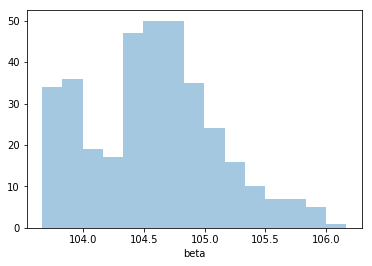

In [9]:
sns.distplot(train[train['sg']==12]['beta'], kde=False, bins=15)

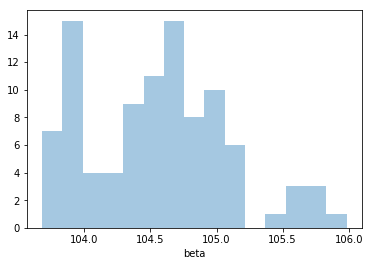

In [10]:
sns.distplot(test[test['sg']==12]['beta'], kde=False, bins=15)

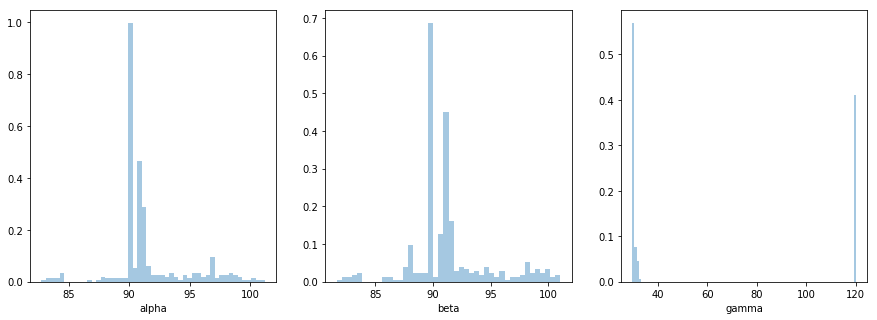

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
bins = [None, None, 100]
for i, angle in enumerate(angle_labels):
    sns.distplot(train[train['sg']==227][angle], ax=ax[i], kde=False, norm_hist=True, bins=bins[i])

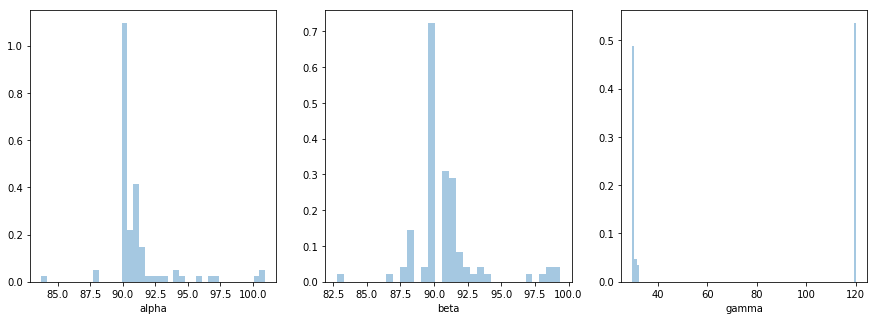

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
bins = [None, None, 100]
for i, angle in enumerate(angle_labels):
    sns.distplot(test[test['sg']==227][angle], ax=ax[i], kde=False, norm_hist=True, bins=bins[i])

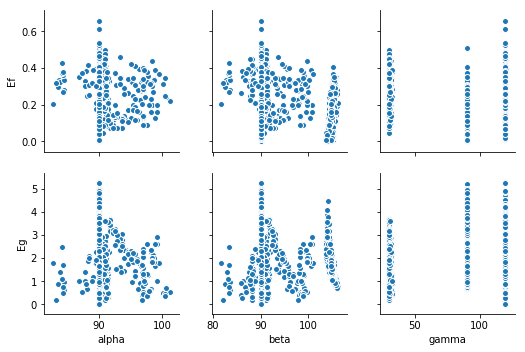

In [13]:
sns.pairplot(train, x_vars=angle_labels, y_vars=['Ef', 'Eg'])

### Lattice vectors

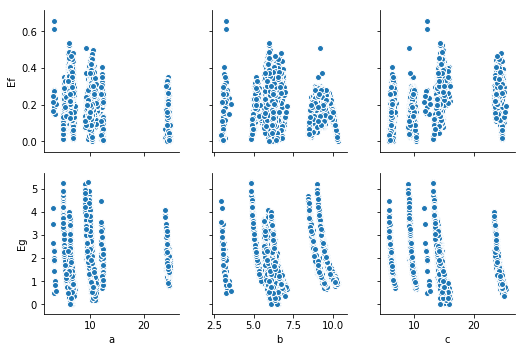

In [14]:
sns.pairplot(train, x_vars=vector_labels, y_vars=['Ef', 'Eg'])

### Composition

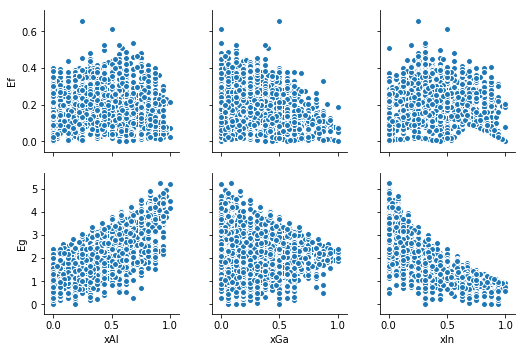

In [15]:
sns.pairplot(train, x_vars=composition_labels, y_vars=['Ef', 'Eg'])

## Feature Engineering

Add feature degree of tetragonality:

In [16]:
for ds in full:
    ds['tetra'] = ds['c'] / ds['a']

Degree to radian:

In [17]:
for ds in full:
    for angle in angle_labels:
        ds[angle] = np.radians(ds[angle])

Checking correlation map:

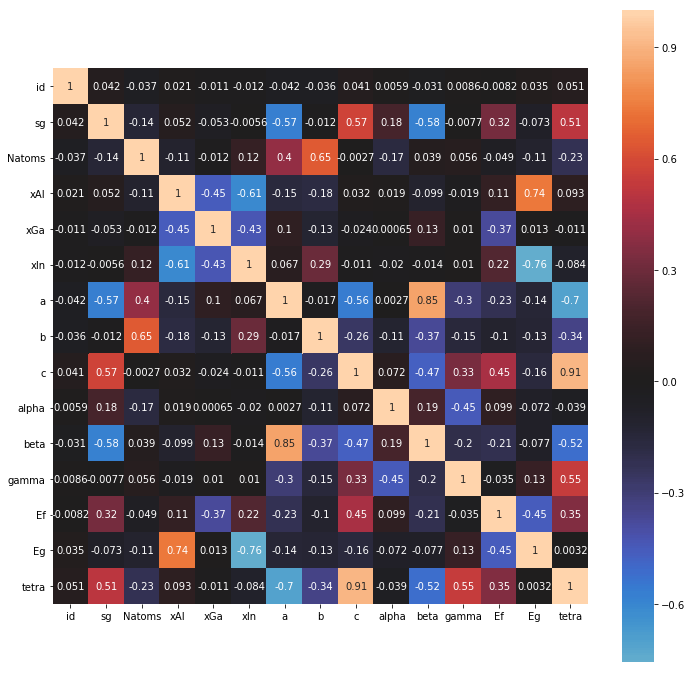

In [18]:
plt.figure(figsize=(12, 12))
sns.heatmap(train.corr(), center=0, square=True, annot=True)

Categorize `Natom` and `sg` (spacegroup):

In [61]:
for ds in full:
    ds['sg'] = ds['sg'].astype(int)
    ds['Natoms'] = ds['Natoms'].astype(int)

In [71]:
X_train = train.drop(labels=['Ef', 'Eg', 'id'], axis=1).values
X_test = test.drop(labels=['id'], axis=1).values
y_train = train[['Ef', 'Eg']].values

## Building model

In [199]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.decomposition import TruncatedSVD

enc = OneHotEncoder(categorical_features=[0, 1])
poly = PolynomialFeatures(degree=4, interaction_only=False, include_bias=False)
tsvd = TruncatedSVD()
rgr = Ridge(normalize=True)

features = FeatureUnion([('enc', enc), ('poly', poly)])
pipe = Pipeline([('features', features), ('tsvd', tsvd), ('rgr', rgr)])

param_grid = dict(tsvd__n_components=[75, 80, 85, 100], rgr__alpha=[0.001, 0.005, 0.01, 0.05, 0.1])

estimator = GridSearchCV(pipe,
                         param_grid=param_grid,
                         return_train_score=True,
                         cv=5,
                         scoring='neg_mean_squared_log_error',
                         n_jobs=-1)
estimator.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('enc', OneHotEncoder(categorical_features=[0, 1], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)), ('poly', PolynomialFeatures(degree=4, include_bias=False, interaction_only=False))],
  ...fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'tsvd__n_components': [75, 80, 85, 100], 'rgr__alpha': [0.001, 0.005, 0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_log_error', verbose=0)

In [202]:
estimator.best_params_, estimator.best_score_, estimator.best_index_

({'rgr__alpha': 0.01, 'tsvd__n_components': 100}, -0.0048307092368001523, 11)

In [201]:
estimator.grid_scores_

/Users/rostyslav.db/.miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.00498, std: 0.00053, params: {'rgr__alpha': 0.001, 'tsvd__n_components': 75},
 mean: -0.00525, std: 0.00093, params: {'rgr__alpha': 0.001, 'tsvd__n_components': 80},
 mean: -0.00549, std: 0.00131, params: {'rgr__alpha': 0.001, 'tsvd__n_components': 85},
 mean: -0.00484, std: 0.00049, params: {'rgr__alpha': 0.001, 'tsvd__n_components': 100},
 mean: -0.00497, std: 0.00053, params: {'rgr__alpha': 0.005, 'tsvd__n_components': 75},
 mean: -0.00524, std: 0.00092, params: {'rgr__alpha': 0.005, 'tsvd__n_components': 80},
 mean: -0.00548, std: 0.00130, params: {'rgr__alpha': 0.005, 'tsvd__n_components': 85},
 mean: -0.00484, std: 0.00048, params: {'rgr__alpha': 0.005, 'tsvd__n_components': 100},
 mean: -0.00497, std: 0.00052, params: {'rgr__alpha': 0.01, 'tsvd__n_components': 75},
 mean: -0.00523, std: 0.00092, params: {'rgr__alpha': 0.01, 'tsvd__n_components': 80},
 mean: -0.00547, std: 0.00129, params: {'rgr__alpha': 0.01, 'tsvd__n_components': 85},
 mean: -0.00483, std: 0.00047, pa

In [203]:
estimator.cv_results_

{'mean_fit_time': array([  7.29177299,   7.79623227,   8.24229736,   9.6208818 ,
          6.12793484,   6.9597209 ,   8.66108932,  10.00226455,
          6.19447384,   7.02086563,   7.42970042,   8.89833484,
          5.78253393,   6.62475724,   7.21858912,   8.99949079,
          6.48602762,   7.49985037,   7.72257738,   8.20694242]),
 'mean_score_time': array([ 0.27107196,  0.26897221,  0.29824066,  0.3416872 ,  0.27809916,
         0.30045156,  0.40296712,  0.37568417,  0.29338627,  0.34454241,
         0.3230588 ,  0.33868399,  0.30058088,  0.33058596,  0.32826676,
         0.35792532,  0.32752209,  0.34931345,  0.33028812,  0.26767335]),
 'mean_test_score': array([-0.00498164, -0.0052454 , -0.00549296, -0.0048414 , -0.00497457,
        -0.00523683, -0.00548142, -0.00483554, -0.00496886, -0.00522927,
        -0.00547032, -0.00483071, -0.00503457, -0.00528082, -0.0054968 ,
        -0.00490387, -0.00534048, -0.00557048, -0.00576212, -0.00521845]),
 'mean_train_score': array([-0.0041

## Submit Prediction

In [204]:
y_pred = estimator.predict(X_test)
submit = pd.DataFrame({'id':test['id'],
                       'formation_energy_ev_natom':y_pred[:, 0],
                       'bandgap_energy_ev':y_pred[:, 1]},
                       columns=['id', 'formation_energy_ev_natom', 'bandgap_energy_ev'])
submit.to_csv('rg_conductor.csv', index=False)
submit.head()

,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.188224,1.593390
1,2,0.080845,3.712486
2,3,0.158814,3.485023
3,4,0.040652,3.010826
4,5,0.114290,1.651807


In [205]:
!head rg_conductor.csv

id,formation_energy_ev_natom,bandgap_energy_ev
1,0.1882237928472575,1.5933902937158109
2,0.08084530906435464,3.7124859356691946
3,0.15881407682781268,3.4850231982960964
4,0.04065189399526206,3.010826386138522
5,0.1142898622155538,1.651806521869251
6,0.04872223455746576,4.3344825382278955
7,0.07235469067679834,3.2195714151035006
8,0.11759479155844274,2.0840186048752387
9,0.07997349397552371,2.6612003987586696
